# 5. Graphical model

We decided to classify the news based on four different types: World, Sports, Business, Sci/Tech.

Used dataset: https://huggingface.co/datasets/fancyzhx/ag_news.
Dataset structure: two splits for train (120,000 records) and test (7,600 records), with two columns:

- 'text': contains string of news content.
- 'label': 0: 'World', 1: 'Sports', 2: 'Business', 3: 'Sci/Tech'

### Import necessary dataset, especially pgmpy for Bayesian Network Model

In [1]:
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import logging
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import KBinsDiscretizer, LabelEncoder, label_binarize, StandardScaler
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import MaximumLikelihoodEstimator
from pgmpy.inference import VariableElimination
from datasets import load_dataset
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
from hmmlearn import hmm
from sklearn.feature_extraction.text import CountVectorizer

ModuleNotFoundError: No module named 'pgmpy'

### Preprocessing data by mapping category and make sample (if necessary)

In [4]:
def load_and_preprocess_data():
    """
    Load data from hugging face dataset and preprocessing, return DataFrame.
    """
    
    # Mapping the label column to the corresponding type
    CATEGORY_MAPPING = {0: 'World', 1: 'Sports', 2: 'Business', 3: 'Sci/Tech'}
    dataset = load_dataset("fancyzhx/ag_news")
    
    # Convert to pandas DataFrame
    train_df = dataset["train"].to_pandas()
    test_df = dataset["test"].to_pandas()
    
    train_df['Category'] = train_df.pop('label').map(CATEGORY_MAPPING)
    test_df['Category'] = test_df.pop('label').map(CATEGORY_MAPPING)
    
    return train_df, test_df

### Building Bayesian Network Classifier to proceed the fit and predict methods

Since Bayesian Network requires categorical input, we need a pipeline to process the input in string format to the output (which is in discrete value) and then fit the model.

Pipeline: string input -> TF-IDF Vectorizer to make vector -> KBinsDiscretizer to create discrete value

In [5]:
class BayesianNetworkClassifier:
    def __init__(self, n_bins=10, max_features=1000):
        # Set max_features to capture all the feature
        self.vectorizer = TfidfVectorizer(stop_words='english', max_features=max_features)
        
        # Discretizer to make discrete value from vector
        self.discretizer = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='uniform')

        # Label encoder to encode y column to discrete value
        self.label_encoder = LabelEncoder()
        self.model = None

    def fit(self, X_train, y_train):
        """
        Fit the Bayesian Network with given X_train and y_train data.
        """
        # Vectorize the text (or X column)
        X_tfidf = self.vectorizer.fit_transform(X_train).toarray()

        # Discretization
        X_disc = self.discretizer.fit_transform(X_tfidf)
        
        # Encode the labels to discrete integer
        y_encoded = self.label_encoder.fit_transform(y_train)
        
        # Each word depends on a word with specific discrete value (or label)
        df = pd.DataFrame(X_disc, columns=[f'word_{i}' for i in range(X_disc.shape[1])])
        df['Category'] = y_encoded
        
        # word ith will depend on the correspond Category due to Naive Bayes
        structure = [('Category', f'word_{i}') for i in range(X_disc.shape[1])]
        self.model = BayesianNetwork(structure)
        
        # fitting with Maximum Likelihood Estimator
        self.model.fit(df, estimator=MaximumLikelihoodEstimator)
    
    def predict(self, X_test):
        """
        Get model prediction for all the data in X_test.
        """
        # transform a string to vector and discretized value before
        X_tfidf = self.vectorizer.transform(X_test).toarray()
        X_disc = self.discretizer.transform(X_tfidf)

        # eliminate unnecessary variable to cut down the computation
        inference = VariableElimination(self.model)

        # fitting process
        predictions = []
        for row in X_disc:
            evidence = {f'word_{i}': int(row[i]) for i in range(len(row))}
            try:
                result = inference.map_query(variables=['Category'], evidence=evidence, show_progress=False)
                predictions.append(int(result['Category']))
            except Exception as e:
                predictions.append(0)
        return self.label_encoder.inverse_transform(predictions)
    
    def predict_proba(self, X_test):
        """
        Probability of each prediction for evaluation.
        """
        # Testing process
        X_tfidf = self.vectorizer.transform(X_test).toarray()
        X_disc = self.discretizer.transform(X_tfidf)
        inference = VariableElimination(self.model)

        # Store probabilities
        prob_predictions = []
        for row in X_disc:
            evidence = {f'word_{i}': int(row[i]) for i in range(len(row))}
            try:
                result = inference.query(variables=['Category'], evidence=evidence, show_progress=False)
                prob_predictions.append(result.values)
            except Exception as e:
                prob_predictions.append(np.zeros(len(self.label_encoder.classes_)))
        return np.array(prob_predictions)

In [7]:
def build_BN_pipeline():
    return BayesianNetworkClassifier()

We can calculate the average of macro-auc score for all the classes.

In [8]:
def calc_roc_auc(y_true, y_pred):
    # Convert y_true and y_pred from labels to numerical values by label_encoder
    label_encoder = bn_classifier.label_encoder
    y_true_encoded = label_encoder.transform(y_true)
    y_pred_encoded = label_encoder.transform(y_pred)

    # One-hot encoding for multiclasses
    classes = np.unique(y_true_encoded)
    y_true_binarized = label_binarize(y_true_encoded, classes=classes)
    y_pred_binarized = label_binarize(y_pred_encoded, classes=classes)

    # Calculate macro-average ROC AUC
    roc_auc = roc_auc_score(y_true_binarized, y_pred_binarized, average="macro", multi_class="ovr")
    
    print(f"Macro-average ROC AUC: {roc_auc:.2f}")

### Main start

In [ ]:
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn")
# Load and preprocessing data
train_df, test_df = load_and_preprocess_data()
X_train, y_train = train_df['text'], train_df['Category']
X_test, y_test = test_df['text'], test_df['Category']
    
# Initialize Bayesian Network and fit the model
bn_classifier = build_BN_pipeline()
print("Fitting model...")
bn_classifier.fit(X_train, y_train)
print("Model fitting completed.")
    
# Predict on test set
print("Predicting on test set...")
y_pred = bn_classifier.predict(X_test)

README.md:   0%|          | 0.00/8.07k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

Fitting model...
Model fitting completed.
Predicting on test set...


/usr/local/lib/python3.10/dist-packages/pgmpy/factors/discrete/DiscreteFactor.py:489: RuntimeWarning: invalid value encountered in divide
  phi.values = phi.values / phi.values.sum()


Classification report

In [27]:
# Classification report for precision, recall and f1-score
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

    Business       0.84      0.73      0.78      1900
    Sci/Tech       0.78      0.81      0.79      1900
      Sports       0.85      0.94      0.90      1900
       World       0.85      0.84      0.84      1900

    accuracy                           0.83      7600
   macro avg       0.83      0.83      0.83      7600
weighted avg       0.83      0.83      0.83      7600



Confusion matrix

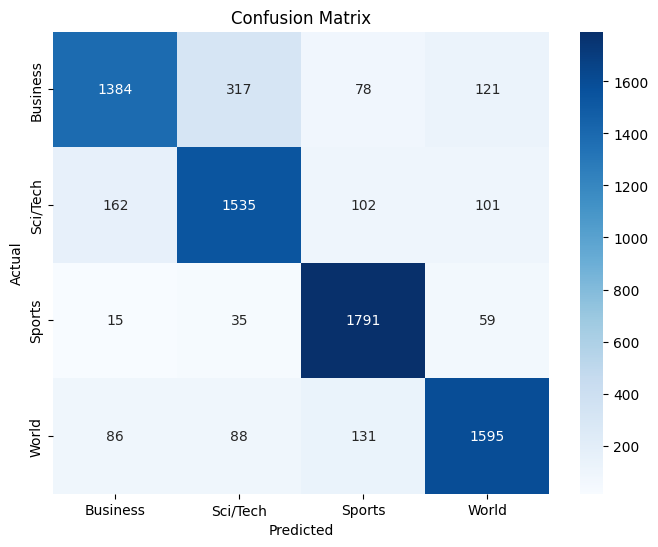

In [28]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=bn_classifier.label_encoder.classes_,
                yticklabels=bn_classifier.label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Macro-AUC average score

In [29]:
# ROC-AUC average score
calc_roc_auc(y_test, y_pred)

Macro-average ROC AUC: 0.89


Model accuracy

In [30]:
# Accuracy
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc * 100:.2f}%")

Accuracy: 82.96%


Performance evaluation with inference time on the 1000-record sample

In [34]:
import time
start_time = time.time()
bn_classifier.predict(X_test[:1000])
inference_time = time.time() - start_time

print(f"Inference time: {inference_time:.4f} seconds")

/usr/local/lib/python3.10/dist-packages/pgmpy/factors/discrete/DiscreteFactor.py:489: RuntimeWarning: invalid value encountered in divide
  phi.values = phi.values / phi.values.sum()


Inference time: 811.8895 seconds


# 2. Hidden Markov Model

We create HMM with 4 hidden layers to avoid overfitting and to capture more complex structure.

Because we use Gaussian HMM then we use Scaler to scale the data to Gaussian distribution.

In [5]:
class HMMClassifier:
    def __init__(self, n_components=5, covariance_type='diag', n_iter=100, max_features=1000):
        self.n_components = n_components
        self.covariance_type = covariance_type
        self.n_iter = n_iter
        self.max_features = max_features
        self.category_hmms = {}
        self.vectorizer = CountVectorizer(max_features=max_features, stop_words="english")
        self.label_encoder = LabelEncoder()

    def fit(self, X_train, y_train):
        y_train_encoded = self.label_encoder.fit_transform(y_train)
        X_train_counts = self.vectorizer.fit_transform(X_train).toarray()
        
        for category in self.label_encoder.classes_:
            idx = y_train == category
            model = hmm.GaussianHMM(n_components=self.n_components, covariance_type=self.covariance_type, n_iter=self.n_iter)
            model.fit(X_train_counts[idx])
            self.category_hmms[category] = model

    def predict(self, X):
        X_counts = self.vectorizer.transform(X).toarray()
        predictions = []
        for sample in X_counts:
            scores = {cat: model.score(sample.reshape(1, -1)) for cat, model in self.category_hmms.items()}
            predicted_category = max(scores, key=scores.get)
            predictions.append(predicted_category)
        return np.array(predictions)
    
    def evaluate(self, X_test, y_test):
        y_test_encoded = self.label_encoder.transform(y_test)
        y_pred = self.predict(X_test)
        y_pred_encoded = self.label_encoder.transform(y_pred)
        
        # Classification Report
        print("=== Classification Report ===")
        print(classification_report(y_test_encoded, y_pred_encoded, target_names=self.label_encoder.classes_))
        
        # Confusion Matrix
        cm = confusion_matrix(y_test_encoded, y_pred_encoded)
        plt.figure(figsize=(8,6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=self.label_encoder.classes_, yticklabels=self.label_encoder.classes_)
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Confusion Matrix')
        plt.show()
        
        # Accuracy
        accuracy = accuracy_score(y_test_encoded, y_pred_encoded)
        print(f'Accuracy: {accuracy * 100:.2f}%')
        return accuracy

In [6]:
def build_HMM_pipeline():
    return HMMClassifier()

=== Classification Report ===
              precision    recall  f1-score   support

    Business       0.53      0.70      0.60      1900
    Sci/Tech       0.64      0.55      0.59      1900
      Sports       0.77      0.67      0.72      1900
       World       0.74      0.71      0.72      1900

    accuracy                           0.65      7600
   macro avg       0.67      0.65      0.66      7600
weighted avg       0.67      0.65      0.66      7600



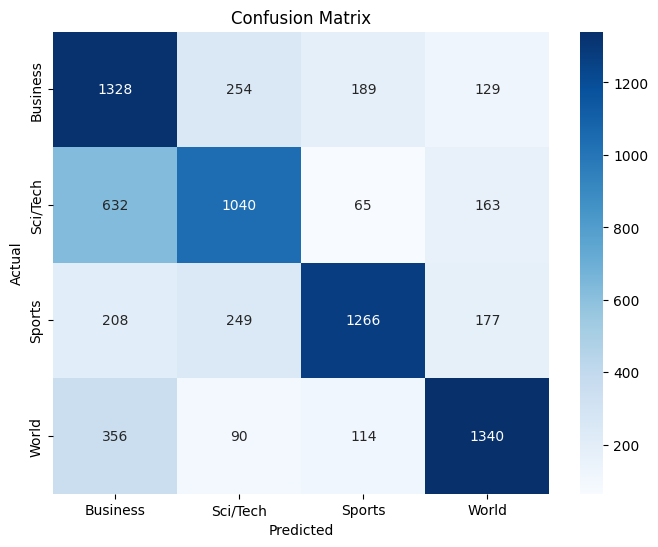

Accuracy: 65.45%


0.6544736842105263

In [9]:
# Load data
train_df, test_df = load_and_preprocess_data()
X_train, y_train = train_df['text'], train_df['Category']
X_test, y_test = test_df['text'], test_df['Category']

# Train HMM model
hmm_classifier = build_HMM_pipeline()
hmm_classifier.fit(X_train, y_train)

hmm_classifier.evaluate(X_test, y_test)